In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Truth Model
def a(t, w): # m/s^2
    return(10*np.sin(w*t))

def v(t, a, w, v_0): # m/s
    v = v_0 + (a/w)-(a/w)*np.cos(w*t)
    return(v)

def p(t, a, w, v_0, p_0):
    p = p_0 + (v_0 + (a/w))*t - (a/w**2)*np.sin(w*t)
    return(p)

# Accelerometer Model
def a_c(a, b, w):
    return(a + b + w)

def v_c(dt, v_c_0, a_c_0):
    return(v_c_0 + a_c_0 * dt)

def p_c(dt, p_c_0, v_c_0, a_c_0):
    return(p_c_0 + v_c_0*dt + a_c_0 * (dt**2)/2)

# Dynamic Model
# Same acceleration

def v_E(dt, v_E_0, a_0):
    return(v_E_0 + a_0 * dt)

def p_E(dt, p_E_0, v_E_0, a_0):
    return(p_E_0 + v_E_0*dt + a_0 * (dt**2)/2)





In [ ]:
w = 0.2 # rad/s
sample_rate_acc = 200.0 # Hz
sample_rate_gps = 5.0 # Hz
dt_gps = 1.0/sample_rate_gps
dt_acc = 1.0/sample_rate_acc
num_samples = int(30*sample_rate_acc) + 1
V = 0.0004 # (m/s^2)^2

b_a = np.random.normal(0, np.sqrt(0.01))
omega = np.random.normal(0, np.sqrt(V), num_samples)

p_mean_0 = 0.0
v_mean_0 = 100.0
M_p_0 = 10.0
M_v_0 = 1.0

v_0 = np.random.normal(v_mean_0, np.sqrt(M_v_0))
p_0 = np.random.normal(p_mean_0, np.sqrt(M_p_0))

V_k = np.array([[1, 0], [0, 0.04]])
[n1i, n2i] = np.random.normal(np.array([0, 0]).T, np.sqrt(v_k))
print(b_a)
print(n1i, n2i)

t = np.arange(num_samples)*dt_acc
print(t)
a_truth = a(t, w)
a_model = a_c(a_truth, b_a, omega)

v_truth = v(t, a_truth, w, v_0)
x_truth = p(t, a_truth, w, v_0, p_0)

[[1.  0. ]
 [0.  0.2]]
-0.047963302230246085
[0.51639919 0.        ] [ 0.        -0.3325621]
[0.0000e+00 5.0000e-03 1.0000e-02 ... 2.9990e+01 2.9995e+01 3.0000e+01]


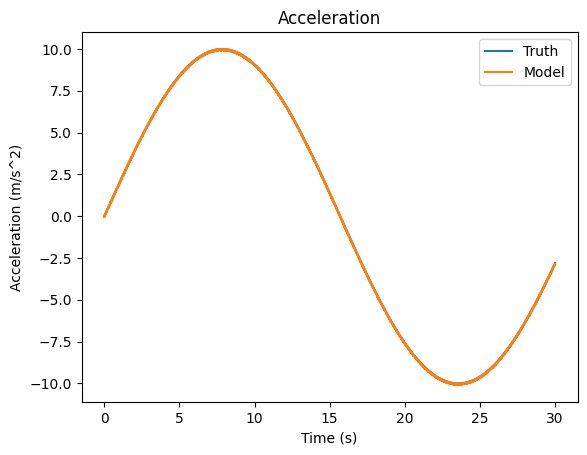

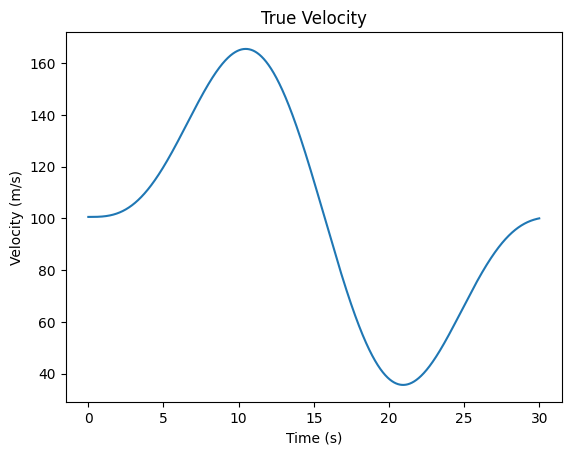

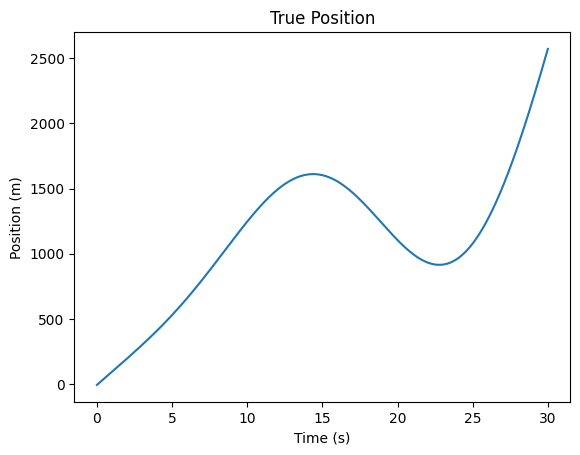

In [18]:
plt.figure()
plt.plot(t, a_truth, label='Truth')
plt.plot(t, a_model, label='Model')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.title("Acceleration")
plt.show()

plt.figure()
plt.plot(t, v_truth)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("True Velocity")
plt.show()

plt.figure()
plt.plot(t, x_truth)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("True Position")
plt.show()




# Kalman Filter Equations

In [ ]:

# Propagation of conditional mean
def E_x_k1(phi_k, x_k_cond_mean):
    return(phi_k @ x_k_cond_mean)

# Covariance generated between measurements
def M_k1(phi_k, P_k, gamma_k, W_k):
    return(phi_k @ P_k @ phi_k.T + gamma_k @ W_k @ gamma_k.T)

# Updating conditional mean
# E_x_k is the expectation of x_k or the first moment/mean
def x_k_cond_mean(E_x_k, P_k, H_k, V_k, z_k):
    residual = z_k - H_k @ E_x_k
    Kalman_gain = P_k @ H_k.T @ V_k.I
    return (E_x_k + Kalman_gain * (residual)) , residual, Kalman_gain


# Updating covariance
def P_k(M_k, H_k, V_k):
    return((M_k.I + H_k.T @ V_k.I @ H_k).I)

In [ ]:
phi = np.array([[1, dt_acc, -dt_acc**2/2],
                [0, 1, -dt_acc],
                [0, 0, 1]])

gamma = np.array([[dt_acc**2/2, dt_acc, 0]]).T


# z_k = H*x_k +v_k
# z_k: actual measurement of x at time k (GPS pos and vel)
# H: connection between state and measurement vector
# v_k: measurement error (defined above)
# x_k: state vector (pos, vel, acc)
H = np.array([[1, 0, 0],
              [0, 1, 0]])




In [51]:
for i in range(num_samples):
    time = t[i]
